In [1]:
# all imports
import numpy as np
import os
import requests
from astropy.table import Table, vstack
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs import WCS
import math
import matplotlib as mpl
from astropy.visualization.wcsaxes import SphericalCircle
import pandas as pd
import random
from matplotlib.patches import Ellipse
import ligo.skymap.plot
from scipy.optimize import minimize
import numdifftools as ndt
from scipy.interpolate import griddata
from matplotlib.tri import Triangulation
from matplotlib.colors import LogNorm
from matplotlib.pyplot import *
from matplotlib.legend_handler import HandlerPatch

In [2]:
# define directories
data_dir = '/global/cfs/projectdirs/desi/science/td/pv/tfgalaxies/'
cache_dir = '/pscratch/sd/j/jjpim/cache/'
scratch_dir = '/pscratch/sd/j/jjpim/'
v_dir = '/pscratch/sd/j/jjpim/massmag/'
hist_dir = '/pscratch/sd/j/jjpim/'

# load updated master table
tf_mastertable = Table.read(data_dir + 'tf_mastertable_massmag_stellar.fits') 

#load SGA table
SGA = Table.read('/global/cfs/cdirs/cosmo/data/sga/2020/SGA-2020.fits', 'ELLIPSE')

#nitya's data
nitya = Table.read(scratch_dir + 'H_alpha_HIvel_BB_refit_ba.fits')

In [3]:
#defining functions
def v_rot(r, v_max, r_turn, alpha):
    '''
    Calculate Rotational Velocity at a target
    Parameters
    ----------
    r : float
        Target distance.
    v_max : float
        Maximum velocity.
    r_turn: float
        Velocity curve turning point.
    alpha : 
        Velocity curve angle.
    Returns
    -------
    Rotational velocity in km / s
    '''
    vrot = (v_max * r) / ((r_turn ** alpha + r ** alpha) ** (1/alpha))
    return vrot

In [4]:
nitya['v_R90']=np.nan

In [5]:
nitya[:5]

plate,ifudsgn,plateifu,mangaid,versdrp2,versdrp3,verscore,versutil,versprim,platetyp,srvymode,objra,objdec,ifuglon,ifuglat,ifura,ifudec,ebvgal,nexp,exptime,drp3qual,bluesn2,redsn2,harname,frlplug,cartid,designid,cenra,cendec,airmsmin,airmsmed,airmsmax,seemin,seemed,seemax,transmin,transmed,transmax,mjdmin,mjdmed,mjdmax,gfwhm,rfwhm,ifwhm,zfwhm,mngtarg1,mngtarg2,mngtarg3,catidnum,plttarg,manga_tileid,nsa_iauname,ifudesignsize,ifutargetsize,ifudesignwrongsize,z,zmin,zmax,szmin,szmax,ezmin,ezmax,probs,pweight,psweight,psrweight,sweight,srweight,eweight,esweight,esrweight,nsa_field,nsa_run,nsa_camcol,nsa_version,nsa_nsaid,nsa_nsaid_v1b,nsa_z,nsa_zdist,nsa_sersic_absmag,nsa_elpetro_absmag,nsa_elpetro_amivar,nsa_sersic_mass,nsa_elpetro_mass,nsa_elpetro_ba,nsa_elpetro_phi,nsa_extinction,nsa_elpetro_th50_r,nsa_petro_th50,nsa_petro_flux,nsa_petro_flux_ivar,nsa_elpetro_flux,nsa_elpetro_flux_ivar,nsa_sersic_ba,nsa_sersic_n,nsa_sersic_phi,nsa_sersic_th50,nsa_sersic_flux,nsa_sersic_flux_ivar,smoothness_score,nsa_elpetro_th90,v_sys,v_sys_err,ba,ba_err,x0,x0_err,y0,y0_err,phi,phi_err,v_max,v_max_err,r_turn,r_turn_err,chi2,alpha,alpha_err,Rmax,M,M_err,fit_flag,Sigma_disk,Sigma_disk_err,R_disk,R_disk_err,rho_bulge,rho_bulge_err,R_bulge,R_bulge_err,M90_disk,M90_disk_err,M_disk,M_disk_err,chi2_disk,logHI,logHIlim,WF50,WF50_err,DL_ttype,vis_tidal,b,b_err,M_R90,M_R90_err,fit_function,A_g,A_r,logH2,R90_kpc,v_3p5,v_3p5_err,NSA_plate,NSA_fiberID,NSA_MJD,logH2_CG,logH2_CG_err,logH2_M,Z,Z_err,M_Z,M_Z_err,grad_Z,grad_Z_err,Z_0,Z_0_err,SFR,sSFR,SFR_err,sSFR_err,Flux_OII_3726,Flux_OII_3726_Err,Flux_OII_3728,Flux_OII_3728_Err,Flux_OIII_4958,Flux_OIII_4958_Err,Flux_OIII_5006,Flux_OIII_5006_Err,Flux_NII_6547,Flux_NII_6547_Err,Flux_NII_6583,Flux_NII_6583_Err,Flux_Ha_6562,Flux_Ha_6562_Err,Flux_Hb_4861,Flux_Hb_4861_Err,CMD_class,rabsmag_NSA,param_H2,param_H2_err,Z_map,Z_err_map,M_Z_map,M_Z_err_map,logHI_R90,v_R90
int64,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,float64,float64,float64,float64,float64,float64,float64,int64,float64,int64,float64,float64,bytes53,int64,bytes32,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,int64,int64,int64,int64,bytes32,int64,bytes19,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,bytes6,int64,int64,float64,float64,float64[7],float64[7],float64[7],float64,float64,float64,float64,float64[7],float64,float64,float64[7],float64[7],float64[7],float64[7],float64,float64,float64,float64,float64[7],float64[7],float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
10001,12701,10001-12701,1-48157,v3_1_1,v3_1_1,v1_9_1,v5_5_36,v2_9,APOGEE-2&MaNGA,MaNGA dither,133.371090612,57.5984251446,159.27921887,38.8381829181,133.37109,57.598425,0.0545561,9,8100.81,0,20.0835,41.292,ma079,22,3,9114,134.41357,57.604214,1.10715,1.15321,1.21404,1.78219,1.85994,2.12685,0.898721,0.929654,0.937466,57372,57373,57373,2.69906,2.64546,2.59645,2.54039,2080,0,0,1,plateTargets-1.par,6013,J085329.03+573554.9,127,127,0,0.0392074,0.0193562,0.0264775,0.0386959,0.0429176,0.0193562,0.0264775,0.748562,-999.0,0.665321,0.705378,1.08

In [6]:
for manga_id in np.unique(nitya['mangaid']):
    galaxy = nitya['mangaid'] == manga_id
    
    # Filter rows using the mask
    r = nitya['R90_kpc'][galaxy]
    v_max = nitya['v_max'][galaxy]
    r_turn = nitya['r_turn'][galaxy]
    alpha = nitya['alpha'][galaxy]
    
    #calculate velocities
    v = v_rot(r, v_max, r_turn, alpha)
    
    # Update the 'v_R90' column for the current manga_id
    nitya['v_R90'][galaxy] = v

In [7]:
#filter for sample requirements + create table
sample = nitya[(nitya['v_max'] > 0) & (nitya['M90_disk'] > 9) & (nitya['alpha'] <= 99) 
                     &((nitya['v_max_err'] / nitya['v_max']) <= 2) & (nitya['v_R90'] < 1000) 
                     & (nitya['v_R90'] > 10)]
print(len(sample))
sample[:5]

5603


plate,ifudsgn,plateifu,mangaid,versdrp2,versdrp3,verscore,versutil,versprim,platetyp,srvymode,objra,objdec,ifuglon,ifuglat,ifura,ifudec,ebvgal,nexp,exptime,drp3qual,bluesn2,redsn2,harname,frlplug,cartid,designid,cenra,cendec,airmsmin,airmsmed,airmsmax,seemin,seemed,seemax,transmin,transmed,transmax,mjdmin,mjdmed,mjdmax,gfwhm,rfwhm,ifwhm,zfwhm,mngtarg1,mngtarg2,mngtarg3,catidnum,plttarg,manga_tileid,nsa_iauname,ifudesignsize,ifutargetsize,ifudesignwrongsize,z,zmin,zmax,szmin,szmax,ezmin,ezmax,probs,pweight,psweight,psrweight,sweight,srweight,eweight,esweight,esrweight,nsa_field,nsa_run,nsa_camcol,nsa_version,nsa_nsaid,nsa_nsaid_v1b,nsa_z,nsa_zdist,nsa_sersic_absmag,nsa_elpetro_absmag,nsa_elpetro_amivar,nsa_sersic_mass,nsa_elpetro_mass,nsa_elpetro_ba,nsa_elpetro_phi,nsa_extinction,nsa_elpetro_th50_r,nsa_petro_th50,nsa_petro_flux,nsa_petro_flux_ivar,nsa_elpetro_flux,nsa_elpetro_flux_ivar,nsa_sersic_ba,nsa_sersic_n,nsa_sersic_phi,nsa_sersic_th50,nsa_sersic_flux,nsa_sersic_flux_ivar,smoothness_score,nsa_elpetro_th90,v_sys,v_sys_err,ba,ba_err,x0,x0_err,y0,y0_err,phi,phi_err,v_max,v_max_err,r_turn,r_turn_err,chi2,alpha,alpha_err,Rmax,M,M_err,fit_flag,Sigma_disk,Sigma_disk_err,R_disk,R_disk_err,rho_bulge,rho_bulge_err,R_bulge,R_bulge_err,M90_disk,M90_disk_err,M_disk,M_disk_err,chi2_disk,logHI,logHIlim,WF50,WF50_err,DL_ttype,vis_tidal,b,b_err,M_R90,M_R90_err,fit_function,A_g,A_r,logH2,R90_kpc,v_3p5,v_3p5_err,NSA_plate,NSA_fiberID,NSA_MJD,logH2_CG,logH2_CG_err,logH2_M,Z,Z_err,M_Z,M_Z_err,grad_Z,grad_Z_err,Z_0,Z_0_err,SFR,sSFR,SFR_err,sSFR_err,Flux_OII_3726,Flux_OII_3726_Err,Flux_OII_3728,Flux_OII_3728_Err,Flux_OIII_4958,Flux_OIII_4958_Err,Flux_OIII_5006,Flux_OIII_5006_Err,Flux_NII_6547,Flux_NII_6547_Err,Flux_NII_6583,Flux_NII_6583_Err,Flux_Ha_6562,Flux_Ha_6562_Err,Flux_Hb_4861,Flux_Hb_4861_Err,CMD_class,rabsmag_NSA,param_H2,param_H2_err,Z_map,Z_err_map,M_Z_map,M_Z_err_map,logHI_R90,v_R90
int64,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,float64,float64,float64,float64,float64,float64,float64,int64,float64,int64,float64,float64,bytes53,int64,bytes32,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,int64,int64,int64,int64,bytes32,int64,bytes19,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,bytes6,int64,int64,float64,float64,float64[7],float64[7],float64[7],float64,float64,float64,float64,float64[7],float64,float64,float64[7],float64[7],float64[7],float64[7],float64,float64,float64,float64,float64[7],float64[7],float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
10001,12701,10001-12701,1-48157,v3_1_1,v3_1_1,v1_9_1,v5_5_36,v2_9,APOGEE-2&MaNGA,MaNGA dither,133.371090612,57.5984251446,159.27921887,38.8381829181,133.37109,57.598425,0.0545561,9,8100.81,0,20.0835,41.292,ma079,22,3,9114,134.41357,57.604214,1.10715,1.15321,1.21404,1.78219,1.85994,2.12685,0.898721,0.929654,0.937466,57372,57373,57373,2.69906,2.64546,2.59645,2.54039,2080,0,0,1,plateTargets-1.par,6013,J085329.03+573554.9,127,127,0,0.0392074,0.0193562,0.0264775,0.0386959,0.0429176,0.0193562,0.0264775,0.748562,-999.0,0.665321,0.705378,1.08

In [8]:
#plotting each mass only once
unique_sga_ids = np.unique(tf_mastertable['SGA_ID'])

# Extract the first occurrence of each unique SGA_ID
unique = []
for sga_id in unique_sga_ids:
    sga = tf_mastertable['SGA_ID'] == sga_id
    unique.append(tf_mastertable[sga][0])  # append first occurrence
    
unique_table = Table(rows=unique, names=tf_mastertable.colnames)

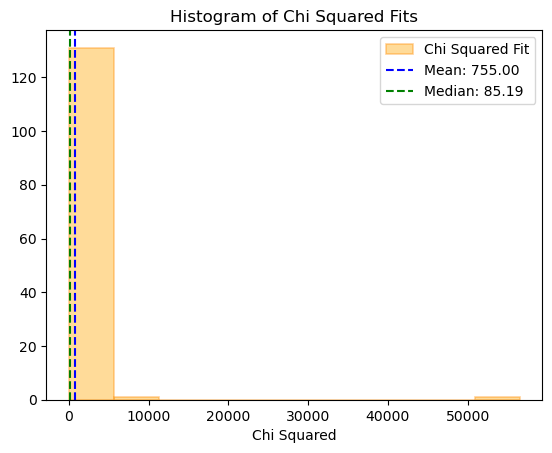

In [9]:
chi_vals = np.array(unique_table['ROTCURVE_CHI2'])

# Remove NaN values and filter for values greater than 0
chi_vals = chi_vals[np.isfinite(chi_vals) & (chi_vals > 0)]

# Plotting
plt.figure()
plt.hist(chi_vals, bins=10, color='orange', alpha=0.4, edgecolor='darkorange', linewidth=1.2, label='Chi Squared Fit')
mean_chi = np.mean(chi_vals)
median_chi = np.median(chi_vals)
plt.axvline(mean_chi, color='blue', linestyle='dashed', linewidth=1.5, label=f'Mean: {mean_chi:.2f}')
plt.axvline(median_chi, color='green', linestyle='dashed', linewidth=1.5, label=f'Median: {median_chi:.2f}')
plt.xlabel(r"Chi Squared")
plt.title("Histogram of Chi Squared Fits")
plt.legend()

# Save plot
plt.savefig(hist_dir + 'histogram_chi2.png')  # Adjust hist_dir if needed

# Show plot
plt.show()

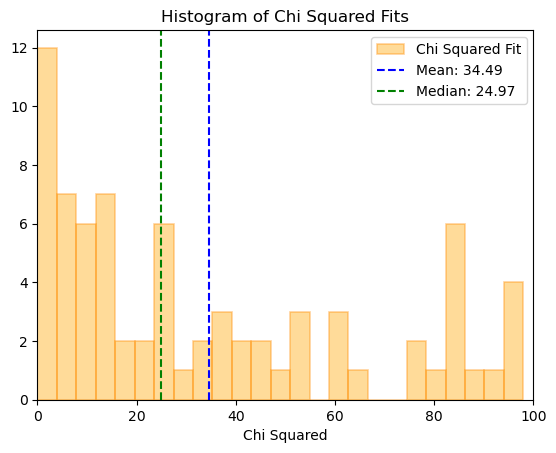

In [18]:
#chi squared values
chi_vals = np.array(unique_table['ROTCURVE_CHI2'])

# remove nans
chi_vals = chi_vals[np.isfinite(chi_vals) & (chi_vals > 0) & (chi_vals < 100)]

# plot hist
plt.figure()
plt.hist(chi_vals, bins=25, color='orange', alpha=0.4, edgecolor='darkorange', linewidth=1.2, label='Chi Squared Fit')
mean_chi = np.mean(chi_vals)
median_chi = np.median(chi_vals)
plt.axvline(mean_chi, color='blue', linestyle='dashed', linewidth=1.5, label=f'Mean: {mean_chi:.2f}')
plt.axvline(median_chi, color='green', linestyle='dashed', linewidth=1.5, label=f'Median: {median_chi:.2f}')

# axis stuff
plt.xlabel(r"Chi Squared")
plt.title("Histogram of Chi Squared Fits")
x_min, x_max = 0, 100  
plt.xlim(x_min, x_max)
plt.legend()

# Save plot
plt.savefig(hist_dir + 'histogram_chi2_zoomed.png') 

# Show plot
plt.show()

In [19]:
unique_table[unique_table['ROTCURVE_CHI2'] > 1000]

TARGETID,TARGET_RA,TARGET_DEC,HEALPIX,SURVEY,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID,RA,DEC,OBS_IN_SV,SKY_FIBER_DIST,SKY_FIBER_DIST_R26,ROT_CURVE,EOA,VELOCITY,VERR,Z_CENTER,ROTCURVE_CHI2,VMAX,VMAX_ERR,RTURN,RTURN_ERR,ALPHA,ALPHA_ERR,INCLINATION,VROT_R26,VROT_R26_ERR,M_R26,M_R26_ERR,VROT_3P5R26,VROT_3P5R26_ERR,M_3P5R26,M_3P5R26_ERR,RABS_MAG26,M_STELLAR_CIGALE,M_STELLAR_CIGALE_ERR,M_STELLAR_PROVABGS,M_STELLAR_PROVABGS_ERR
int64,float64,float64,int64,str4,float64,float64,int64,float64,str65,str3,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,int64
2407968851099651,184.342593480355,37.7850060326633,10888,main,0.00100644346133428,8.35058046554285e-06,0,3496.46422497931,iron/healpix/main/dark/108/10888/redrock-main-dark-10888.fits,EXT,526710,184.3425934803552,37.78500603266333,0.0,0.03457473028924321,0.20000001317238564,1.0,1.0,60.41881339517397,2.613817327752631,0.000804907993103208,1620.671500578106,986.2803319836213,2957498.2079804623,5.072317880090448,15210.047128846978,12.882730137524147,40435.50967084366,1.539168277357325,985.5565595684812,3076840.91688062,12.21597716702563,3.7955230349994284,986.2803319123797,3058136.9619267383,12.760682851031769,3.7925565814215556,-12.912834715415388,--,--,--,--
1070120059273219,182.127412589385,0.137628714970505,26281,sv3,0.0354513708407024,4.18285673014397e-06,0,2012.18079049402,fuji/healpix/sv3/bright/262/26281/redrock-sv3-bright-26281.fits,TFT,550458,182.1274125893848,0.1376287149705046,1.0,0.0032267460305578544,0.3300000160429451,1.0,0.0,175.3024877246147,2.9014490955848764,0.03486662468366394,1037.7160400949242,489.91191576612124,--,1.0619555551252906,--,98.28585948718028,--,1.000415426473583,489.9119157661212,0.0,11.998034450293156,--,489.91191576612124,0.0,--,--,-20.683351306469312,10.440186891298463,--,10.629129409790039,--
1070083774349316,179.389604615224,-1.26137257073619,25598,sv3,0.0178435157310394,8.28262826437585e-06,0,248.968790740706,fuji/healpix/sv3/bright/255/25598/redrock-sv3-bright-25598.fits,TFT,671533,179.38960461522427,-1.2613725707361938,1.0,0.01084241815682121,0.6700000394571287,1.0,0.0,-163.60082245307456,2.581049094177253,0.018389229334191733,2139.330773539032,193.2538141188053,1.094720776199907,0.41548404716677284,0.0032295083363384773,99.3279581256578,91496.02203068435,1.4723096837998266,193.25381411880528,4920.318541562194,11.131008711627938,1.715341300399956,193.25381411880528,7165.524421521383,11.675076755978214,1.8759672161067513,-19.378246843085783,10.018323732933755,--,10.007641792297363,--
1084109115883522,252.295989519777,35.3183341531131,9429,sv3,0.0977884038947062,4.70706411598944e-06,0,2070.32185333967,fuji/healpix/sv3/dark/94/9429/redrock-sv3-dark-9429.fits,TFT,916161,252.2959895197768,35.318334153113085,1.0,0.0016631410370806167,0.3299999842416476,1.0,0.0,274.43518561255536,1.7727073028221743,0.0968729866509123,2238.1266968388736,481.9271967430312,21.44301236620229,0.18365552889423886,0.06576694919232624,0.6929071946730745,0.026066610330431426,1.2973044026214358,460.04320151736715,80.584951764273,12.099352808687614,0.13044199186805372,472.5306837691664,115.28104451499468,12.666683648133239,0.17258261911402428,-20.655536731409022,10.484066733360837,--,10.925840377807617,--
2407864991744014,190.399569329198,32.5304436669536,10761,main,0.00154087114844486,5.70509534207211e-06,0,749.824635429017,iron/healpix/main/dark/107/10761/redrock-main-dark-10761.fits,EXT,977015,190.39956932919756,32.5304436669536,0.0,0.11281951666332472,0.600000038063093,0.0,1.0,-177.91515831759332,1.7209081584731405,0.0021343322365073,6539.323153537301,201.9196360903838,7.421459257594428,0.35810287020804143,0.00811713305991824,1.164138200247244,0.06279752491732687,1.539168277357325,200.41564104791985,28.9004843385893,11.292497501632484,0.11005256253950257,201.56761411531795,40.71

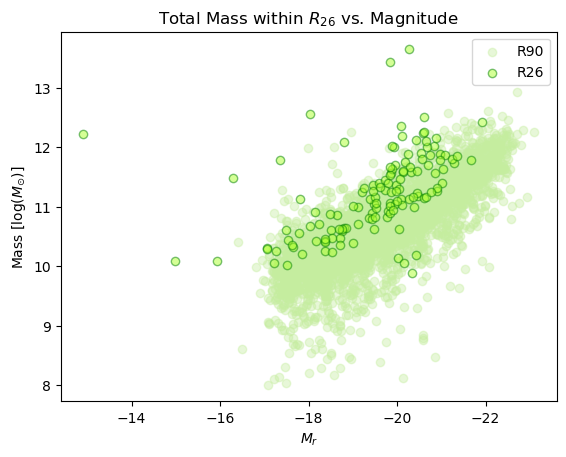

In [11]:
#plotting R26 mass vs magnitude in context of R90 mass
y = unique_table['M_R26']
x = unique_table['RABS_MAG26']

w = sample['rabsmag_NSA']
z = sample['M_R90']

#plot
plt.scatter(w, z, marker='o', color='#c5ed9f', alpha = 0.4, label = 'R90')
plt.scatter(x, y, marker='o', color='#adff2f', alpha = 0.5, edgecolors = 'green', label = 'R26')
plt.gca().invert_xaxis()
#plt.ylim(8, 14.5)
plt.ylabel(r"Mass [$\log(M_{\odot})$]")
plt.xlabel(r"$M_{r}$")
plt.legend()
plt.title(r"Total Mass within $R_{26}$ vs. Magnitude")
# img_name = v_dir + 'Mass_Mag'
plt.savefig(v_dir + 'context_r26_mass_magplot.png', dpi=300)

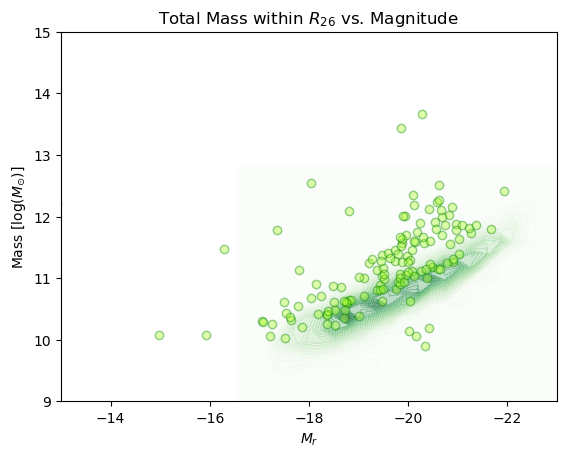

In [12]:
y = unique_table['M_R26']
x = unique_table['RABS_MAG26']
w = sample['rabsmag_NSA']
z = sample['M_R90']

# create linspace
x_grid = np.linspace(min(w), max(w), 25)
y_grid = np.linspace(min(z), max(z), 25)

# 2d histogram to find density
Z, xedges, yedges = np.histogram2d(w, z, bins=[x_grid, y_grid])

# find bin centers
x_centers = 0.5 * (xedges[:-1] + xedges[1:])
y_centers = 0.5 * (yedges[:-1] + yedges[1:])
X, Y = np.meshgrid(x_centers, y_centers)

Z = Z.T

# contour plotting
cont = plt.contourf(X, Y, Z, levels= 50, cmap='Greens', alpha = 0.3)

# scatter plot
plt.scatter(x, y, marker='o', color='#adff2f', alpha=0.4, edgecolors='green', label='R26')
plt.gca().invert_xaxis()

# axis stuff
plt.ylim(9, 15)
plt.xlim(-13, -23)
plt.ylabel(r"Mass [$\log(M_{\odot})$]")
plt.xlabel(r"$M_{r}$")
plt.title(r"Total Mass within $R_{26}$ vs. Magnitude")
plt.savefig(v_dir + 'contour_context_r26_mass_magplot.png', dpi=300)
plt.show()

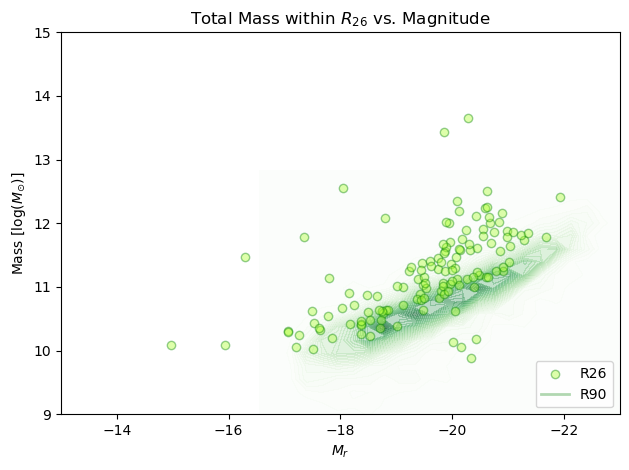

In [50]:
#my data
y = unique_table['M_R26']
x = unique_table['RABS_MAG26']
#nityas data
w = sample['rabsmag_NSA']
z = sample['M_R90']

# create linspace
x_grid = np.linspace(min(w), max(w), 25)
y_grid = np.linspace(min(z), max(z), 25)

# 2d histogram to find density
Z, xedges, yedges = np.histogram2d(w, z, bins=[x_grid, y_grid])

# Find bin centers
x_centers = 0.5 * (xedges[:-1] + xedges[1:])
y_centers = 0.5 * (yedges[:-1] + yedges[1:])
X, Y = np.meshgrid(x_centers, y_centers)

Z = Z.T

# contour plotting
plt.figure(tight_layout=True)
cont = plt.contourf(X, Y, Z, levels=50, cmap='Greens', alpha=0.3)

# scatter plotting
r26 = plt.scatter(x, y, marker='o', color='#adff2f', alpha=0.4, edgecolors='green', label='R26')

# make contour label
cont_plot = plt.Line2D([0], [0], color='Green', lw=2, linestyle='-', alpha=0.3, label='R90')

# axis stuff
plt.gca().invert_xaxis() 
plt.ylim(9, 15)
plt.xlim(-13, -23)

# legend
plt.legend(handles=[r26, cont_plot], loc='lower right')

# labels
plt.ylabel(r"Mass [$\log(M_{\odot})$]")
plt.xlabel(r"$M_{r}$")
plt.title(r"Total Mass within $R_{26}$ vs. Magnitude")
plt.savefig(v_dir + 'labeled_contour_context_r26_mass_magplot.png', dpi=300)
plt.show()

In [13]:
print(len(x), len(y), len(w), len(z))

75171 75171 5603 5603


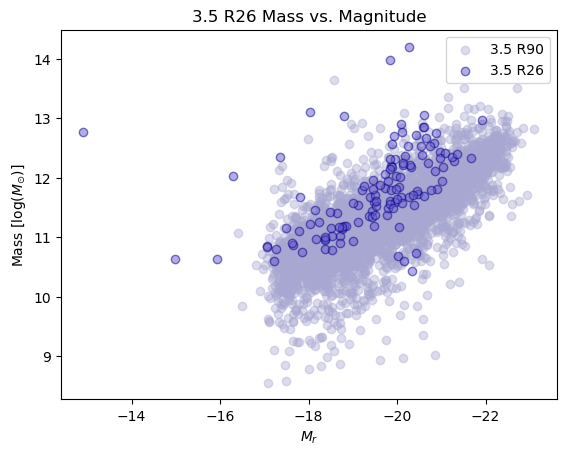

In [14]:
#plotting 3.5 R26 mass vs magnitude in context of 3.5 R90 mass
x = unique_table['RABS_MAG26']
y = unique_table['M_3P5R26']

w = sample['rabsmag_NSA']
z = sample['M']

plt.scatter(w, z, marker='o', color='#a8a7d1', alpha = 0.4, label = '3.5 R90')
plt.scatter(x, y, marker='o', color='slateblue', alpha = 0.5, edgecolors = 'darkblue', label = '3.5 R26')
plt.gca().invert_xaxis()
#plt.ylim(8, 14.5)
plt.ylabel(r"Mass [$\log(M_{\odot})$]")
plt.xlabel(r"$M_{r}$")
plt.legend()
plt.title("3.5 R26 Mass vs. Magnitude")
# img_name = v_dir + 'Mass_Mag'
plt.savefig(v_dir + 'context_3p5r26_mass_magplot.png', dpi=300)

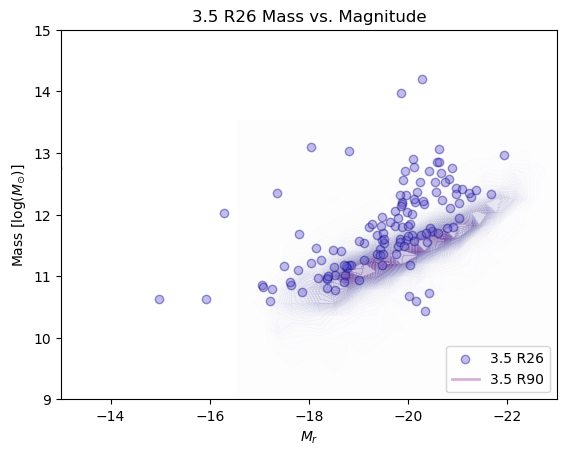

In [52]:
x = unique_table['RABS_MAG26']
y = unique_table['M_3P5R26']
w = sample['rabsmag_NSA']
z = sample['M']

# create linspace
x_grid = np.linspace(min(w), max(w), 25)
y_grid = np.linspace(min(z), max(z), 25)

# 2d histogram to find density
Z, xedges, yedges = np.histogram2d(w, z, bins=[x_grid, y_grid])

# find bin centers
x_centers = 0.5 * (xedges[:-1] + xedges[1:])
y_centers = 0.5 * (yedges[:-1] + yedges[1:])
X, Y = np.meshgrid(x_centers, y_centers)

Z = Z.T

# contour plotting
cont = plt.contourf(X, Y, Z, levels= 50, cmap='Purples', alpha = 0.3)

# make contour label
cont_plot = plt.Line2D([0], [0], color='Purple', lw=2, linestyle='-', alpha=0.3, label='3.5 R90')

# scatter plot
r26_3p5 = plt.scatter(x, y, marker='o', color='slateblue', alpha = 0.4, edgecolors = 'darkblue', label = '3.5 R26')
plt.gca().invert_xaxis()

#plot stuff
plt.ylim(9, 15)
plt.xlim(-13, -23)
plt.ylabel(r"Mass [$\log(M_{\odot})$]")
plt.xlabel(r"$M_{r}$")
plt.title("3.5 R26 Mass vs. Magnitude")
plt.legend(handles=[r26_3p5, cont_plot], loc='lower right')
plt.savefig(v_dir + 'labeled_context_3p5r26_mass_magplot.png', dpi=300)
plt.show()

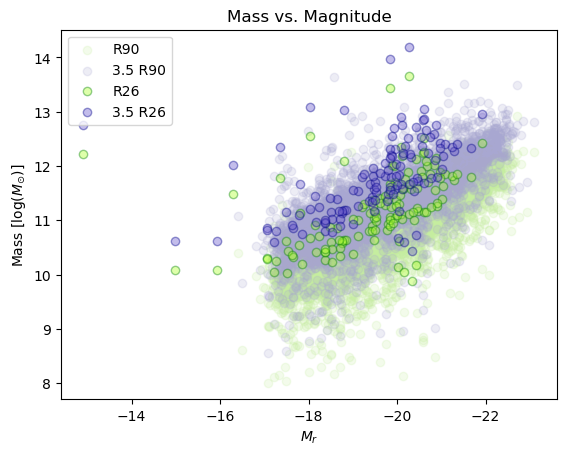

In [16]:
#plotting R26 and 3.5 R26 mass vs magnitude in context of R90 and 3.5 R90 mass
#my data
x = unique_table['RABS_MAG26']
y = unique_table['M_R26']
w = unique_table['RABS_MAG26']
z = unique_table['M_3P5R26']
#nityas data
a = sample['rabsmag_NSA']
b = sample['M']
c = sample['rabsmag_NSA']
d = sample['M_R90']
#plot
plt.scatter(c, d, marker='o', color='#c5ed9f', alpha = 0.2, label = 'R90')
plt.scatter(a, b, marker='o', color='#a8a7d1', alpha = 0.2, label = '3.5 R90')
plt.scatter(x, y, marker='o', color='#adff2f', alpha = 0.4, edgecolors = 'green', label = 'R26')
plt.scatter(w, z, marker='o',  color='slateblue', alpha = 0.4, edgecolors = 'darkblue', label = '3.5 R26')
plt.gca().invert_xaxis()
#plt.ylim(8, 14.5)
plt.ylabel(r"Mass [$\log(M_{\odot})$]")
plt.xlabel(r"$M_{r}$")
plt.title("Mass vs. Magnitude")
plt.legend()
# img_name = v_dir + 'Mass_Mag'
plt.savefig(v_dir + 'context_r26_3p5r26__mass_magplot.png', dpi=300)

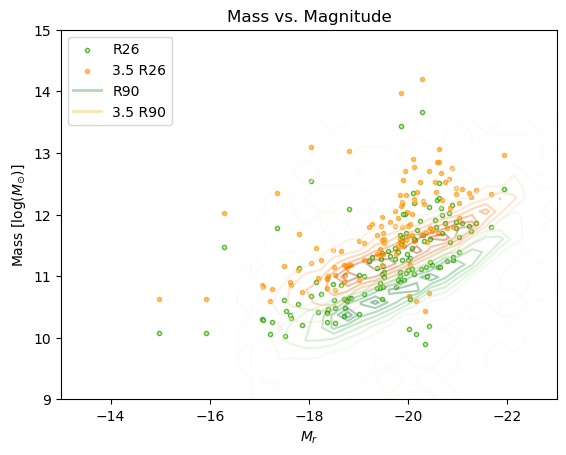

In [23]:
#my data
x = unique_table['RABS_MAG26']
y = unique_table['M_R26']
w = unique_table['RABS_MAG26']
z = unique_table['M_3P5R26']
#nityas data
a = sample['rabsmag_NSA']
b = sample['M']
c = sample['rabsmag_NSA']
d = sample['M_R90']
# create linspaces
x_grid = np.linspace(min(a), max(a), 25)
y_grid = np.linspace(min(b), max(b), 25)
c_grid = np.linspace(min(c), max(c), 25)
d_grid = np.linspace(min(d), max(d), 25)

# 2d histograms to find density
Z, xedges, yedges = np.histogram2d(a, b, bins=[x_grid, y_grid])
C, cedges, dedges = np.histogram2d(c, d, bins=[c_grid, d_grid])

# find bin centers
x_centers = 0.5 * (xedges[:-1] + xedges[1:])
y_centers = 0.5 * (yedges[:-1] + yedges[1:])
c_centers = 0.5 * (cedges[:-1] + cedges[1:])
d_centers = 0.5 * (dedges[:-1] + dedges[1:])
X, Y = np.meshgrid(x_centers, y_centers)
A, B = np.meshgrid(c_centers, d_centers)

Z = Z.T
C = C.T

# contour plotting
cont = plt.contour(X, Y, Z, levels= 8, cmap='Oranges', alpha = 0.4)
cont_2 = plt.contour(A, B, C, levels= 8, cmap='Greens', alpha = 0.4)

# make contour labels
cont_plot_2 = plt.Line2D([0], [0], color='Green', lw=2, linestyle='-', alpha=0.3, label='R90')
cont_plot = plt.Line2D([0], [0], color='Orange', lw=2, linestyle='-', alpha=0.3, label='3.5 R90')

# scatter plot
r26 = plt.scatter(x, y, marker='.', color='#adff2f', alpha = 0.6, edgecolors = 'green', label = 'R26')
r26_3p5 = plt.scatter(w, z, marker='.',  color='orange', alpha = 0.6, edgecolors = 'darkorange', label = '3.5 R26')

plt.gca().invert_xaxis()

#plot stuff
plt.ylim(9, 15)
plt.xlim(-13, -23)
plt.ylabel(r"Mass [$\log(M_{\odot})$]")
plt.xlabel(r"$M_{r}$")
plt.title("Mass vs. Magnitude")
plt.legend(handles=[r26, r26_3p5, cont_plot_2, cont_plot], loc='upper left')
plt.savefig(v_dir + 'contour_context_r26_3p5r26_mass_magplot.png', dpi=300)
plt.show()

# Stellar Mass Plots

In [18]:
# read in first table
table = Table.read('/global/cfs/cdirs/desi/public/edr/vac/edr/cigale/fuji/v1.1/FujiPhysProp_v1.1.fits')
#read in second table
table_2 = Table.read('/global/cfs/cdirs/desi/public/edr/vac/edr/provabgs/v1.0/BGS_ANY_full.provabgs.sv3.v0.hdf5')

# find common target ids
t1 = table[table['LOGM'] > 0]
t2 = table_2[table_2['PROVABGS_LOGMSTAR_BF'] > 0]
common_ids = np.intersect1d(t1['TARGETID'], t2['TARGETID'])

# define function
def filter_table_by_ids(table, common_ids):
    return table[np.in1d(table['TARGETID'], common_ids)]

common_data_table = filter_table_by_ids(t1, common_ids)
common_data_table_2 = filter_table_by_ids(t2, common_ids)

# sort by targetid
common_data_table.sort('TARGETID')
common_data_table_2.sort('TARGETID')

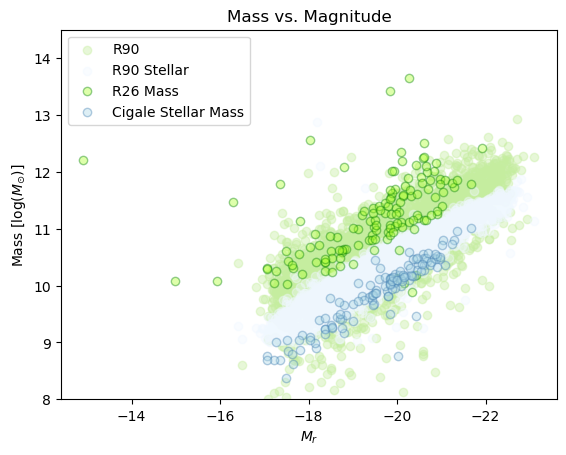

In [36]:
#total mass vs. cigale stellar mass in context of R90 and stellar mass in R90
#my data
x = unique_table['RABS_MAG26']
y = unique_table['M_R26']
w = unique_table['RABS_MAG26']
z = unique_table['M_STELLAR_CIGALE']

#nityas data
a = sample['rabsmag_NSA']
b = sample['M_R90']
c = sample['rabsmag_NSA']
d = sample['M90_disk']

#plot
plt.scatter(a, b, marker='o', color='#c5ed9f', alpha = 0.4, label = 'R90')
plt.scatter(c, d, marker='o', color='aliceblue', alpha = 0.4, label = 'R90 Stellar')
plt.scatter(x, y, marker='o', color='#adff2f', alpha = 0.4, edgecolors = 'green', label = 'R26 Mass')
plt.scatter(w, z, marker='o', color='lightblue', alpha = 0.4, edgecolors = 'steelblue', label = 'Cigale Stellar Mass')
plt.gca().invert_xaxis()
plt.ylim(8, 14.5)
plt.ylabel(r"Mass [$\log(M_{\odot})$]")
plt.xlabel(r"$M_{r}$")
plt.title("Mass vs. Magnitude")
plt.legend()
plt.savefig(v_dir + 'context_cigale_stellar_total__mass_magplot.png', dpi=300)

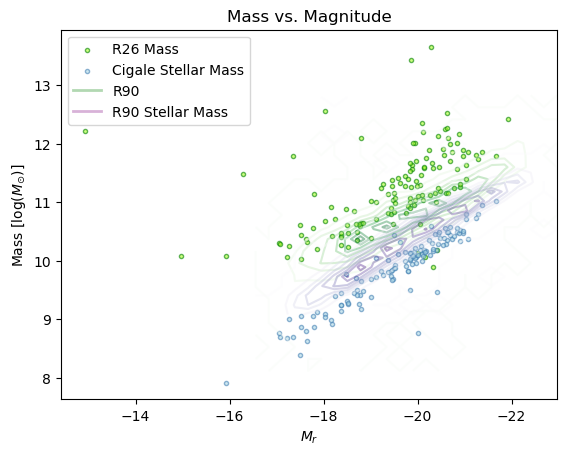

In [58]:
#total mass vs. cigale stellar mass in context of R90 and stellar mass in R90
#my data
x = unique_table['RABS_MAG26']
y = unique_table['M_R26']
w = unique_table['RABS_MAG26']
z = unique_table['M_STELLAR_CIGALE']

#nityas data
a = sample['rabsmag_NSA']
b = sample['M_R90']
c = sample['rabsmag_NSA']
d = sample['M90_disk']

# create linspaces
x_grid = np.linspace(min(a), max(a), 25)
y_grid = np.linspace(min(b), max(b), 25)
c_grid = np.linspace(min(c), max(c), 25)
d_grid = np.linspace(min(d), max(d), 25)

# 2d histograms to find density
Z, xedges, yedges = np.histogram2d(a, b, bins=[x_grid, y_grid])
C, cedges, dedges = np.histogram2d(c, d, bins=[c_grid, d_grid])

# find bin centers
x_centers = 0.5 * (xedges[:-1] + xedges[1:])
y_centers = 0.5 * (yedges[:-1] + yedges[1:])
c_centers = 0.5 * (cedges[:-1] + cedges[1:])
d_centers = 0.5 * (dedges[:-1] + dedges[1:])
X, Y = np.meshgrid(x_centers, y_centers)
A, B = np.meshgrid(c_centers, d_centers)

Z = Z.T #for R90
C = C.T #for R90 stellar

# contour plotting
cont = plt.contour(X, Y, Z, levels= 8, cmap='Greens', alpha = 0.4)
cont_2 = plt.contour(A, B, C, levels= 8, cmap='Purples', alpha = 0.4)

# make contour labels
cont_plot = plt.Line2D([0], [0], color='Green', lw=2, linestyle='-', alpha=0.3, label='R90')
cont_plot_2 = plt.Line2D([0], [0], color='Purple', lw=2, linestyle='-', alpha=0.3, label='R90 Stellar Mass')


#plot
r26 = plt.scatter(x, y, marker='.', color='#adff2f', alpha = 0.6, edgecolors = 'green', label = 'R26 Mass')
cigale = plt.scatter(w, z, marker='.', color='lightblue', alpha = 0.6, edgecolors = 'steelblue', label = 'Cigale Stellar Mass')

#axis stuff
plt.gca().invert_xaxis()
#plt.ylim(8, 14.5)
plt.ylabel(r"Mass [$\log(M_{\odot})$]")
plt.xlabel(r"$M_{r}$")
plt.title("Mass vs. Magnitude")
plt.legend(handles=[r26, cigale, cont_plot, cont_plot_2], loc='upper left')
plt.savefig(v_dir + 'contour_context_cigale_stellar_total__mass_magplot.png', dpi=300)
plt.show()

In [21]:
light_green = '#c5ed9f' #for R26 plotting
bright_green = '#adff2f' #for R90 plotting in scatters
med_blue = '#a8a7d1' #for R90 stellar in scatters

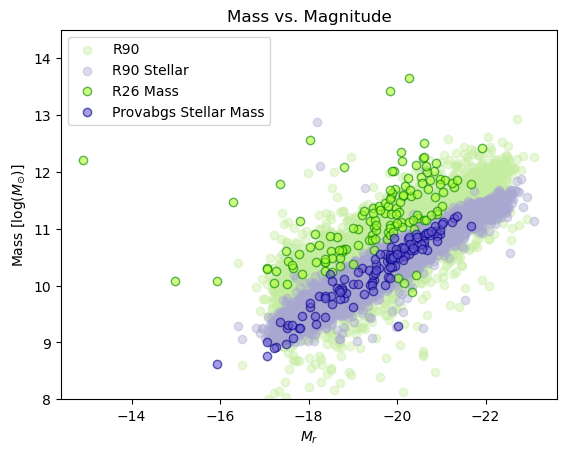

In [35]:
#total mass vs. provabgs stellar mass in context of R90 and stellar mass in R90
#my data
x = unique_table['RABS_MAG26']
y = unique_table['M_R26']
z = unique_table['M_STELLAR_PROVABGS']

#nityas data
a = sample['rabsmag_NSA']
b = sample['M_R90']
c = sample['rabsmag_NSA']
d = sample['M90_disk']

#plot
plt.scatter(a, b, marker='o', color='#c5ed9f', alpha = 0.4, label = 'R90') #R90
plt.scatter(c, d, marker='o', color='#a8a7d1', alpha = 0.4, label= 'R90 Stellar') #R90 stellar
plt.scatter(x, y, marker='o', color='#adff2f', alpha = 0.6, edgecolors = 'green', label = 'R26 Mass')
plt.scatter(x, z, marker='o', color='slateblue', alpha = 0.6, edgecolors = 'darkblue', label = 'Provabgs Stellar Mass')
plt.gca().invert_xaxis()
plt.ylim(8, 14.5)
plt.ylabel(r"Mass [$\log(M_{\odot})$]")
plt.xlabel(r"$M_{r}$")
plt.title("Mass vs. Magnitude")
plt.legend()
plt.savefig(v_dir + 'context_provabgs_stellar_total__mass_magplot.png', dpi=300)

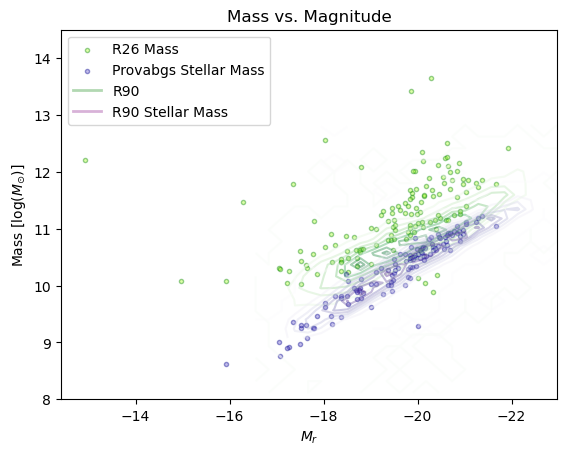

In [59]:
#total mass vs. provabgs stellar mass in context of R90 and stellar mass in R90
#my data
x = unique_table['RABS_MAG26']
y = unique_table['M_R26']
z = unique_table['M_STELLAR_PROVABGS']

#nityas data
a = sample['rabsmag_NSA']
b = sample['M_R90']
c = sample['rabsmag_NSA']
d = sample['M90_disk']

# create linspaces
x_grid = np.linspace(min(a), max(a), 25)
y_grid = np.linspace(min(b), max(b), 25)
c_grid = np.linspace(min(c), max(c), 25)
d_grid = np.linspace(min(d), max(d), 25)

# 2d histograms to find density
Z, xedges, yedges = np.histogram2d(a, b, bins=[x_grid, y_grid])
C, cedges, dedges = np.histogram2d(c, d, bins=[c_grid, d_grid])

# find bin centers
x_centers = 0.5 * (xedges[:-1] + xedges[1:])
y_centers = 0.5 * (yedges[:-1] + yedges[1:])
c_centers = 0.5 * (cedges[:-1] + cedges[1:])
d_centers = 0.5 * (dedges[:-1] + dedges[1:])
X, Y = np.meshgrid(x_centers, y_centers)
A, B = np.meshgrid(c_centers, d_centers)

Z = Z.T 
C = C.T 

#contour plot nityas data
cont = plt.contour(X, Y, Z, levels= 8, cmap='Greens', alpha = 0.4) #R90
cont_2 = plt.contour(A, B, C, levels= 8, cmap='Purples', alpha = 0.4) #R90 stellar

#make labels
cont_plot = plt.Line2D([0], [0], color='Green', lw=2, linestyle='-', alpha=0.3, label='R90')
cont_plot_2 = plt.Line2D([0], [0], color='Purple', lw=2, linestyle='-', alpha=0.3, label='R90 Stellar Mass')

#scatter plot
r26 = plt.scatter(x, y, marker='.', color='#adff2f', alpha = 0.4, edgecolors = 'green', label = 'R26 Mass')
prova = plt.scatter(x, z, marker='.', color='slateblue', alpha = 0.4, edgecolors = 'darkblue', label = 'Provabgs Stellar Mass')
plt.gca().invert_xaxis()
plt.ylim(8, 14.5)
plt.ylabel(r"Mass [$\log(M_{\odot})$]")
plt.xlabel(r"$M_{r}$")
plt.title("Mass vs. Magnitude")
plt.legend(handles=[r26, prova, cont_plot, cont_plot_2], loc='upper left')
plt.savefig(v_dir + 'contour_context_provabgs_stellar_total__mass_magplot.png', dpi=300)

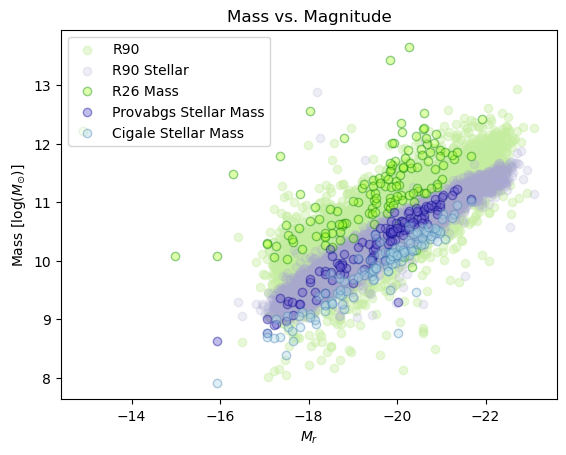

In [24]:
#total mass vs. provabgs and cegale stellar mass in context of R90 and stellar mass in R90
#plotting
x = unique_table['RABS_MAG26']
y = unique_table['M_R26']
w = unique_table['M_STELLAR_CIGALE']
z = unique_table['M_STELLAR_PROVABGS']

#nityas data
a = sample['rabsmag_NSA']
b = sample['M_R90']
c = sample['rabsmag_NSA']
d = sample['M90_disk']

#plot
plt.scatter(a, b, marker='o', color= light_green, alpha = 0.4, label = 'R90') 
plt.scatter(c, d, marker='o', color= med_blue, alpha = 0.2, label = 'R90 Stellar')
plt.scatter(x, y, marker='o', color=bright_green, alpha = 0.4, edgecolors = 'green', label = 'R26 Mass')
plt.scatter(x, z, marker='o', color='slateblue', alpha = 0.4, edgecolors = 'darkblue', label = 'Provabgs Stellar Mass')
plt.scatter(x, w, marker='o', color='lightblue', alpha = 0.4, edgecolors = 'steelblue', label = 'Cigale Stellar Mass')
plt.gca().invert_xaxis()
plt.ylabel(r"Mass [$\log(M_{\odot})$]")
plt.xlabel(r"$M_{r}$")
plt.title("Mass vs. Magnitude")
plt.legend()
plt.savefig(v_dir + 'context_both_stellar_total__mass_magplot.png', dpi=300)

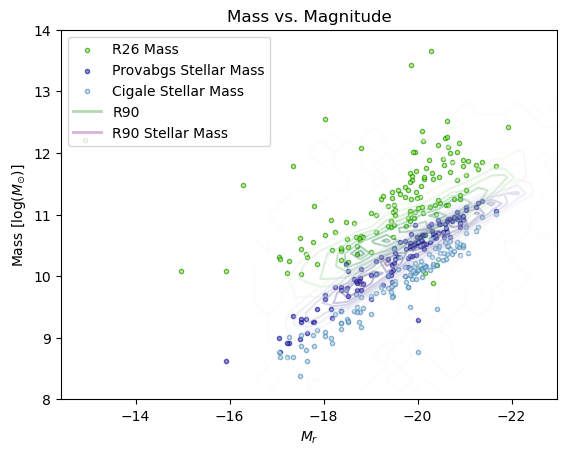

In [21]:
#total mass vs. provabgs and cegale stellar mass in context of R90 and stellar mass in R90
#plotting
x = unique_table['RABS_MAG26']
y = unique_table['M_R26']
w = unique_table['M_STELLAR_CIGALE']
z = unique_table['M_STELLAR_PROVABGS']

#nityas data
a = sample['rabsmag_NSA']
b = sample['M_R90']
c = sample['rabsmag_NSA']
d = sample['M90_disk']

# create linspaces
x_grid = np.linspace(min(a), max(a), 25)
y_grid = np.linspace(min(b), max(b), 25)
c_grid = np.linspace(min(c), max(c), 25)
d_grid = np.linspace(min(d), max(d), 25)

# 2d histograms to find density
Z, xedges, yedges = np.histogram2d(a, b, bins=[x_grid, y_grid])
C, cedges, dedges = np.histogram2d(c, d, bins=[c_grid, d_grid])

# find bin centers
x_centers = 0.5 * (xedges[:-1] + xedges[1:])
y_centers = 0.5 * (yedges[:-1] + yedges[1:])
c_centers = 0.5 * (cedges[:-1] + cedges[1:])
d_centers = 0.5 * (dedges[:-1] + dedges[1:])
X, Y = np.meshgrid(x_centers, y_centers)
A, B = np.meshgrid(c_centers, d_centers)

Z = Z.T 
C = C.T 

#contour plot nityas data
cont = plt.contour(X, Y, Z, levels= 8, cmap='Greens', alpha = 0.4) #R90
cont_2 = plt.contour(A, B, C, levels= 8, cmap='Purples', alpha = 0.4) #R90 stellar

#make labels
cont_plot = plt.Line2D([0], [0], color='Green', lw=2, linestyle='-', alpha=0.3, label='R90')
cont_plot_2 = plt.Line2D([0], [0], color='Purple', lw=2, linestyle='-', alpha=0.3, label='R90 Stellar Mass')

#plot
r26 = plt.scatter(x, y, marker='.', color='#adff2f', alpha = 0.6, edgecolors = 'green', label = 'R26 Mass')
prova = plt.scatter(x, z, marker='.', color='#5452bf', alpha = 0.6, edgecolors = 'darkblue', label = 'Provabgs Stellar Mass')
cigale = plt.scatter(x, w, marker='.', color='lightblue', alpha = 0.6, edgecolors = 'steelblue', label = 'Cigale Stellar Mass')
plt.gca().invert_xaxis()
plt.ylim(8, 14)
plt.ylabel(r"Mass [$\log(M_{\odot})$]")
plt.xlabel(r"$M_{r}$")
plt.title("Mass vs. Magnitude")
plt.legend(handles=[r26, prova, cigale, cont_plot, cont_plot_2], loc='upper left')
plt.savefig(v_dir + 'contour_context_both_stellar_total__mass_magplot.png', dpi=300)

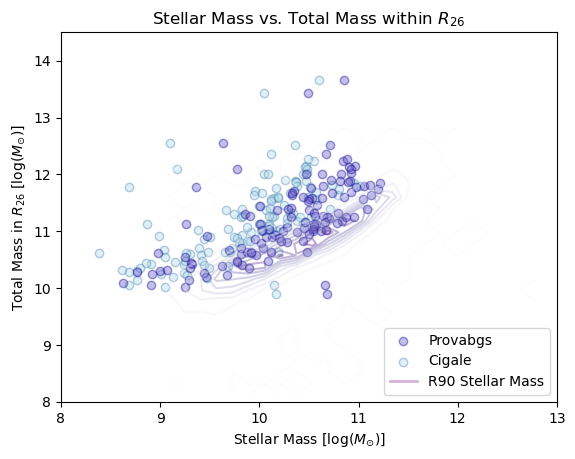

In [75]:
#stellar mass vs total mass R26 for both
#plotting
y = unique_table['M_R26']
x_cigale = unique_table['M_STELLAR_CIGALE']
x_provabgs = unique_table['M_STELLAR_PROVABGS']

#nityas data
a = sample['M90_disk']
b = sample['M_R90']

# create linspaces
x_grid = np.linspace(min(a), max(a), 25)
y_grid = np.linspace(min(b), max(b), 25)

# 2d histograms to find density
Z, xedges, yedges = np.histogram2d(a, b, bins=[x_grid, y_grid])

# find bin centers
x_centers = 0.5 * (xedges[:-1] + xedges[1:])
y_centers = 0.5 * (yedges[:-1] + yedges[1:])

X, Y = np.meshgrid(x_centers, y_centers)

Z = Z.T 

#plot!
cont = plt.contour(X, Y, Z, levels= 8, cmap='Purples', alpha = 0.4) #R90 stellar

#make labels
cont_plot = plt.Line2D([0], [0], color='Purple', lw=2, linestyle='-', alpha=0.3, label='R90 Stellar Mass')

#scatter plot
cigale = plt.scatter(x_cigale, y, marker='o', color='lightblue', alpha = 0.4, edgecolors = 'steelblue', label = 'Cigale')
prova = plt.scatter(x_provabgs, y, marker='o', color='slateblue', alpha = 0.4, edgecolors = 'darkblue', label = 'Provabgs')

plt.ylim(8, 14.5)
plt.xlim(8, 13)
plt.ylabel(r"Total Mass in $R_{26}$ [$\log(M_{\odot})$]")
plt.xlabel(r"Stellar Mass [$\log(M_{\odot})$]")
plt.title(r"Stellar Mass vs. Total Mass within $R_{26}$")
plt.legend(handles=[prova, cigale, cont_plot], loc='lower right')
plt.savefig(v_dir + 'contour_context_stellar_total__mass_plot.png', dpi=300)
plt.show()

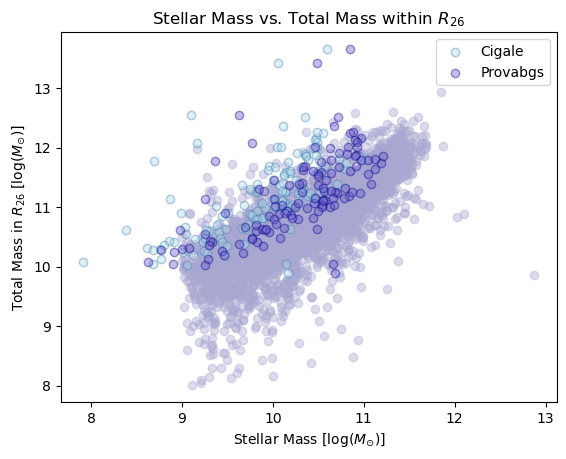

In [32]:
#stellar mass vs total mass R26 for both
#plotting
y = unique_table['M_R26']
x_cigale = unique_table['M_STELLAR_CIGALE']
x_provabgs = unique_table['M_STELLAR_PROVABGS']

#nityas data
a = sample['M90_disk']
b = sample['M_R90']

#plot
plt.scatter(a, b, marker='o', color=med_blue, alpha = 0.4)
plt.scatter(x_cigale, y, marker='o', color='lightblue', alpha = 0.4, edgecolors = 'steelblue', label = 'Cigale')
plt.scatter(x_provabgs, y, marker='o', color='slateblue', alpha = 0.4, edgecolors = 'darkblue', label = 'Provabgs')
#plt.ylim(7.5, 14)
#plt.xlim(7.5, 14)
#plt.plot([7.5, 14], [7.5,14], ls = ':')
plt.ylabel(r"Total Mass in $R_{26}$ [$\log(M_{\odot})$]")
plt.xlabel(r"Stellar Mass [$\log(M_{\odot})$]")
plt.title(r"Stellar Mass vs. Total Mass within $R_{26}$")
plt.legend()
plt.savefig(v_dir + 'context_stellar_total__mass_plot.png', dpi=300)
plt.show()

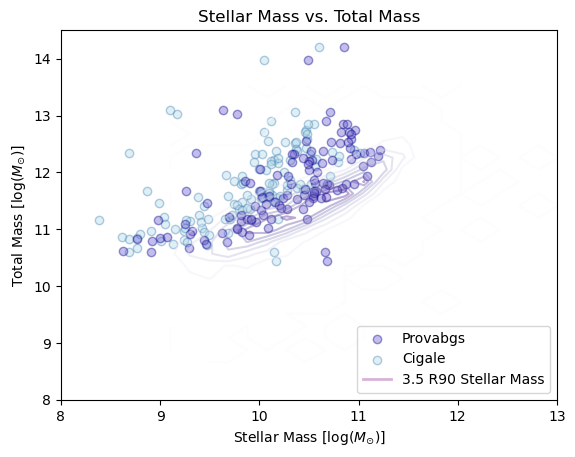

In [74]:
#stellar mass vs total mass 3.5 R26 for both
#my data
x_cigale = unique_table['M_STELLAR_CIGALE']
x_provabgs = unique_table['M_STELLAR_PROVABGS']
y = unique_table['M_3P5R26']

#nityas data
a = sample['M_disk']
b = sample['M']

# create linspaces
x_grid = np.linspace(min(a), max(a), 25)
y_grid = np.linspace(min(b), max(b), 25)
c_grid = np.linspace(min(c), max(c), 25)

# 2d histograms to find density
Z, xedges, yedges = np.histogram2d(a, b, bins=[x_grid, y_grid])

# find bin centers
x_centers = 0.5 * (xedges[:-1] + xedges[1:])
y_centers = 0.5 * (yedges[:-1] + yedges[1:])

X, Y = np.meshgrid(x_centers, y_centers)

Z = Z.T 

#plot!
cont = plt.contour(X, Y, Z, levels= 8, cmap='Purples', alpha = 0.4) #3.5 R90 vs stellar

#make labels
cont_plot = plt.Line2D([0], [0], color='Purple', lw=2, linestyle='-', alpha=0.3, label='3.5 R90 Stellar Mass')

#plot
cigale = plt.scatter(x_cigale, y, marker='o', color='lightblue', alpha = 0.4, edgecolors = 'steelblue', label = 'Cigale')
prova = plt.scatter(x_provabgs, y, marker='o', color='slateblue', alpha = 0.4, edgecolors = 'darkblue', label = 'Provabgs')

plt.ylim(8, 14.5)
plt.xlim(8, 13)
plt.ylabel(r"Total Mass [$\log(M_{\odot})$]")
plt.xlabel(r"Stellar Mass [$\log(M_{\odot})$]")
plt.title(r"Stellar Mass vs. Total Mass")
plt.legend(handles=[prova, cigale, cont_plot], loc='lower right')
plt.savefig(v_dir + 'contour_stellar_3p5_total__mass_plot.png', dpi=300)
plt.show()

/tmp/ipykernel_30676/2248422074.py:12: RuntimeWarning: divide by zero encountered in log
  ratio_c = 10 ** (np.log(m_star_cigale) - np.log(m_tot))
/tmp/ipykernel_30676/2248422074.py:13: RuntimeWarning: divide by zero encountered in log
  ratio_p = 10 ** (np.log(m_star_provabgs) - np.log(m_tot))


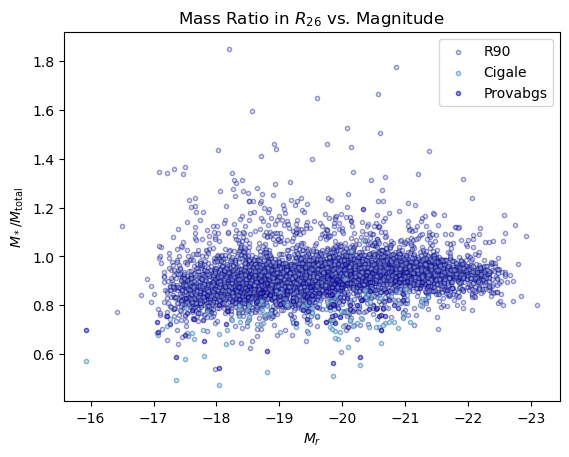

In [29]:
#ratio stellar mass to total mass within R26 using cigale and provabgs
m_star_cigale = unique_table['M_STELLAR_CIGALE']
m_star_provabgs = unique_table['M_STELLAR_PROVABGS']
mag = unique_table['RABS_MAG26']
m_tot = unique_table['M_R26']

#nitya data
m_star = sample['M90_disk']
m_tot_s = sample['M_R90']
mag_s = sample['rabsmag_NSA']

ratio_c = 10 ** (np.log(m_star_cigale) - np.log(m_tot))
ratio_p = 10 ** (np.log(m_star_provabgs) - np.log(m_tot))
ratio_s = 10 ** (np.log(m_star) - np.log(m_tot_s))

#plot
plt.scatter(mag_s, ratio_s, marker='.', color='lightsteelblue', alpha=0.4, edgecolors='darkblue', label='R90')
plt.scatter(mag, ratio_c, marker='.', color='lightblue', alpha = 0.6, edgecolors = 'steelblue', label = 'Cigale')
plt.scatter(mag, ratio_p, marker='.', color='slateblue', alpha=0.6, edgecolors='darkblue', label='Provabgs')

plt.gca().invert_xaxis()
#plt.ylim(0.70, 1.10)
#plt.xlim(-15.5, -22.5)
plt.ylabel(r'$M_*/M_{\text{total}}$')
plt.xlabel(r"$M_{r}$")
plt.legend()
plt.title(r"Mass Ratio in $R_{26}$ vs. Magnitude")
plt.savefig(v_dir + 'context_r26_mass_ratio_plot.png', dpi=300)
plt.show()

/tmp/ipykernel_876034/370135690.py:12: RuntimeWarning: divide by zero encountered in log
  ratio_c = 10 ** (np.log(m_star_cigale) - np.log(m_tot))
/tmp/ipykernel_876034/370135690.py:13: RuntimeWarning: divide by zero encountered in log
  ratio_p = 10 ** (np.log(m_star_provabgs) - np.log(m_tot))


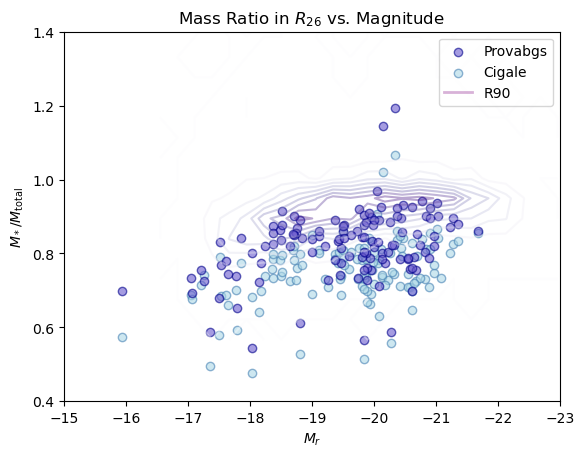

In [20]:
#ratio stellar mass to total mass within R26 using cigale and provabgs
m_star_cigale = unique_table['M_STELLAR_CIGALE']
m_star_provabgs = unique_table['M_STELLAR_PROVABGS']
mag = unique_table['RABS_MAG26']
m_tot = unique_table['M_R26']

#nitya data
m_star = sample['M90_disk']
m_tot_s = sample['M_R90']
a = sample['rabsmag_NSA']

ratio_c = 10 ** (np.log(m_star_cigale) - np.log(m_tot))
ratio_p = 10 ** (np.log(m_star_provabgs) - np.log(m_tot))
b = 10 ** (np.log(m_star) - np.log(m_tot_s))

# create linspaces
x_grid = np.linspace(min(a), max(a), 25)
y_grid = np.linspace(min(b), max(b), 25)

# 2d histograms to find density
Z, xedges, yedges = np.histogram2d(a, b, bins=[x_grid, y_grid])

# find bin centers
x_centers = 0.5 * (xedges[:-1] + xedges[1:])
y_centers = 0.5 * (yedges[:-1] + yedges[1:])

X, Y = np.meshgrid(x_centers, y_centers)

Z = Z.T 

#plot!

cigale = plt.scatter(mag, ratio_c, marker='o', color='lightblue', alpha = 0.6, edgecolors = 'steelblue', label = 'Cigale')
prova = plt.scatter(mag, ratio_p, marker='o', color='slateblue', alpha=0.6, edgecolors='darkblue', label='Provabgs')
cont = plt.contour(X, Y, Z, levels= 8, cmap='Purples', alpha = 0.4) #R90 vs stellar

#make labels
cont_plot = plt.Line2D([0], [0], color='Purple', lw=2, linestyle='-', alpha=0.3, label='R90')
plt.legend(handles=[prova, cigale, cont_plot])

plt.gca().invert_xaxis()
plt.xlim(-15, -23)
plt.ylim(0.4, 1.4)
plt.ylabel(r'$M_*/M_{\text{total}}$')
plt.xlabel(r"$M_{r}$")
plt.title(r"Mass Ratio in $R_{26}$ vs. Magnitude")
plt.savefig(v_dir + 'contour_context_r26_mass_ratio_plot.png', dpi=300)
plt.show()

/tmp/ipykernel_1373298/3826707748.py:12: RuntimeWarning: divide by zero encountered in log
  ratio_c = 10 ** (np.log(m_star_cigale) - np.log(m_tot))
/tmp/ipykernel_1373298/3826707748.py:13: RuntimeWarning: divide by zero encountered in log
  ratio_p = 10 ** (np.log(m_star_provabgs) - np.log(m_tot))


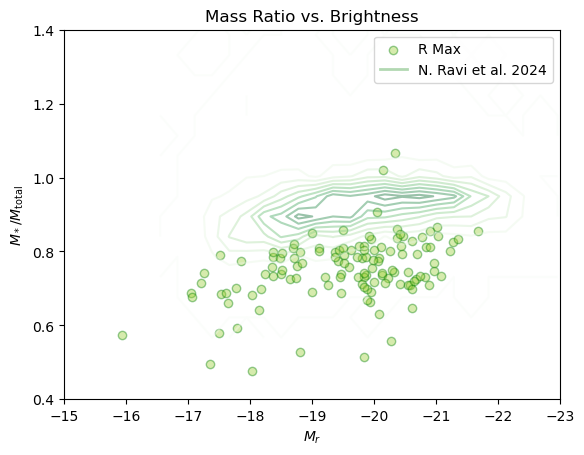

In [14]:
#ratio stellar mass to total mass within R26 using cigale and provabgs
m_star_cigale = unique_table['M_STELLAR_CIGALE']
m_star_provabgs = unique_table['M_STELLAR_PROVABGS']
mag = unique_table['RABS_MAG26']
m_tot = unique_table['M_R26']

#nitya data
m_star = sample['M90_disk']
m_tot_s = sample['M_R90']
a = sample['rabsmag_NSA']

ratio_c = 10 ** (np.log(m_star_cigale) - np.log(m_tot))
ratio_p = 10 ** (np.log(m_star_provabgs) - np.log(m_tot))
b = 10 ** (np.log(m_star) - np.log(m_tot_s))

# create linspaces
x_grid = np.linspace(min(a), max(a), 25)
y_grid = np.linspace(min(b), max(b), 25)

# 2d histograms to find density
Z, xedges, yedges = np.histogram2d(a, b, bins=[x_grid, y_grid])

# find bin centers
x_centers = 0.5 * (xedges[:-1] + xedges[1:])
y_centers = 0.5 * (yedges[:-1] + yedges[1:])

X, Y = np.meshgrid(x_centers, y_centers)

Z = Z.T 

#plot!

cigale = plt.scatter(mag, ratio_c, marker='o', color='yellowgreen', alpha = 0.4, edgecolors = 'Green', label = 'R Max')
cont = plt.contour(X, Y, Z, levels= 8, cmap='Greens', alpha = 0.4) #R90 vs stellar

#make labels
cont_plot = plt.Line2D([0], [0], color='Green', lw=2, linestyle='-', alpha=0.3, label='N. Ravi et al. 2024')
plt.legend(handles=[cigale, cont_plot])

plt.gca().invert_xaxis()
plt.xlim(-15, -23)
plt.ylim(0.4, 1.4)
plt.ylabel(r'$M_*/M_{\text{total}}$')
plt.xlabel(r"$M_{r}$")
plt.title(r"Mass Ratio vs. Brightness")
plt.savefig(v_dir + 'contour_context_r26_mass_ratio_plot.png', dpi=300)
plt.show()

/tmp/ipykernel_30676/3079787250.py:12: RuntimeWarning: divide by zero encountered in log
  ratio_c = 10 ** (np.log(m_star_cigale) - np.log(m_tot))
/tmp/ipykernel_30676/3079787250.py:13: RuntimeWarning: divide by zero encountered in log
  ratio_p = 10 ** (np.log(m_star_provabgs) - np.log(m_tot))


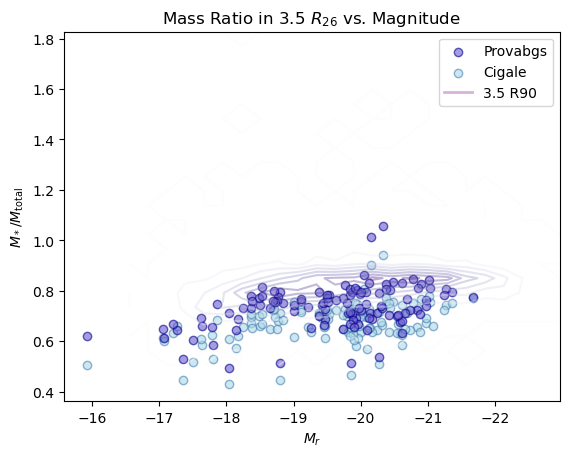

In [78]:
#ratio stellar mass to total mass within R26 using cigale and provabgs
m_star_cigale = unique_table['M_STELLAR_CIGALE']
m_star_provabgs = unique_table['M_STELLAR_PROVABGS']
mag = unique_table['RABS_MAG26']
m_tot = unique_table['M_3P5R26']

#nitya data
m_star = sample['M_disk']
m_tot_s = sample['M']
a = sample['rabsmag_NSA']

ratio_c = 10 ** (np.log(m_star_cigale) - np.log(m_tot))
ratio_p = 10 ** (np.log(m_star_provabgs) - np.log(m_tot))
b = 10 ** (np.log(m_star) - np.log(m_tot_s))

# create linspaces
x_grid = np.linspace(min(a), max(a), 25)
y_grid = np.linspace(min(b), max(b), 25)

# 2d histograms to find density
Z, xedges, yedges = np.histogram2d(a, b, bins=[x_grid, y_grid])

# find bin centers
x_centers = 0.5 * (xedges[:-1] + xedges[1:])
y_centers = 0.5 * (yedges[:-1] + yedges[1:])

X, Y = np.meshgrid(x_centers, y_centers)

Z = Z.T 

#plot!

cigale = plt.scatter(mag, ratio_c, marker='o', color='lightblue', alpha = 0.6, edgecolors = 'steelblue', label = 'Cigale')
prova = plt.scatter(mag, ratio_p, marker='o', color='slateblue', alpha=0.6, edgecolors='darkblue', label='Provabgs')
cont = plt.contour(X, Y, Z, levels= 8, cmap='Purples', alpha = 0.4) #3.5 R90 vs stellar

#make labels
cont_plot = plt.Line2D([0], [0], color='Purple', lw=2, linestyle='-', alpha=0.3, label='3.5 R90')
plt.legend(handles=[prova, cigale, cont_plot])

plt.gca().invert_xaxis()
plt.ylabel(r'$M_*/M_{\text{total}}$')
plt.xlabel(r"$M_{r}$")
plt.title(r"Mass Ratio in 3.5 $R_{26}$ vs. Magnitude")
plt.savefig(v_dir + 'contour_context_3p5_r26_mass_ratio_plot.png', dpi=300)
plt.show()